In [26]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [27]:
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')
os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING_V2')

In [28]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-2025-04-14")

In [29]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from typing import List
from langchain.tools import tool
from langchain_community.utilities.serpapi import SerpAPIWrapper
from langchain_community.utilities.google_serper import GoogleSerperAPIWrapper
import requests
from bs4 import BeautifulSoup

In [30]:
class ResearchAgent:
    def __init__(self):
        # Search Tools
        self.search_tool = DuckDuckGoSearchRun()
        self.serp_search = self._init_serpapi()
        self.serper_search = self._init_serperapi()

        # LLM Init
        self.llm = ChatOpenAI(model="gpt-4.1-2025-04-14")

        # Tool Binding
        self.tools = self._setup_tools()
        self.llm_with_tools = self.llm.bind_tools(self.tools)

    def _init_serpapi(self):
        try:
            key = os.getenv("SERPAPI_KEY")
            return SerpAPIWrapper(serpapi_api_key=key) if key else None
        except Exception:
            return None

    def _init_serperapi(self):
        try:
            key = os.getenv("SERPER_API_KEY")
            return GoogleSerperAPIWrapper(serper_api_key=key) if key else None
        except Exception:
            return None

    def _scrape_web(self, url: str, max_length: int = 1000) -> str:
        """Basic HTML scraper with text cleaning."""
        try:
            headers = {"User-Agent": "Mozilla/5.0"}
            response = requests.get(url, headers=headers, timeout=10)
            soup = BeautifulSoup(response.text, "html.parser")
            text = soup.get_text(separator="\n")
            clean_text = "\n".join(line.strip() for line in text.splitlines() if line.strip())
            return clean_text[:max_length]
        except Exception as e:
            return f"Web scraping failed: {repr(e)}"

    def _setup_tools(self) -> List:
        """Define and bind all research tools."""

        @tool
        def research_topic(query: str) -> str:
            """Multi-source research on a topic."""
            if self.serp_search:
                try:
                    result = self.serp_search.run(query)
                    if result and len(result) > 50:
                        return f"From SerpAPI:\n{result}"
                except:
                    pass

            if self.serper_search:
                try:
                    result = self.serper_search.run(query)
                    if result and len(result) > 50:
                        return f"From SerperAPI:\n{result}"
                except:
                    pass

            return f"From DuckDuckGo:\n{self.search_tool.invoke(query)}"

        @tool
        def arxiv_tool(query: str) -> str:
            """Get summaries from arXiv research papers."""
            url = f"https://arxiv.org/search/?query={query}&searchtype=all"
            return self._scrape_web(url)

        @tool
        def medium_tool(query: str) -> str:
            """Get blog content from Medium."""
            url = f"https://medium.com/search?q={query}"
            return self._scrape_web(url)

        @tool
        def reddit_tool(query: str) -> str:
            """Mine discussions from Reddit."""
            url = f"https://www.reddit.com/search/?q={query}"
            return self._scrape_web(url)

        @tool
        def github_tool(query: str) -> str:
            """Track developer trends from GitHub."""
            url = f"https://github.com/search?q={query}"
            return self._scrape_web(url)

        return [research_topic, arxiv_tool, medium_tool, reddit_tool, github_tool]

In [31]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from typing import List,Annotated
from langchain_experimental.utilities import PythonREPL
class SummaryAgent:
    def __init__(self):
        # LLM for summarization (use DeepSeek or GPT-4o if needed)
        self.llm =  ChatOpenAI(model="gpt-4.1-2025-04-14")
        self.tools = self._setup_tools()
        self.llm_with_tools = self.llm.bind_tools(self.tools)

    def _setup_tools(self) -> List:
        """Tool to summarize long research texts into clean insights."""

        @tool
        def summarize_research(raw_content: str) -> str:
            """
            Summarize raw research content into key takeaways,
            quotes, and insight bullets.
            """
            prompt = f"""
            You are an expert research summarizer.

            Your job is to convert the following raw research content into a **detailed, structured, and highly readable summary**.

            Structure your output like this:

            ---

            ###  Overview
            A 2-3 line plain English summary of the topic.

            ###  Key Insights
            List 4–6 *clearly written* bullet points. Each bullet should:
            - Contain one full insight (not vague)
            - Reference any stat, event, or date if mentioned
            - Be written in active voice

            ###  Deep Dives (if applicable)
            Elaborate on any complex concepts or trends found in the content.
            - Write in clear paragraphs (2-3 max)
            - Use analogies or examples if needed

            ###  Quotes & References
            Extract any notable quotes, citations, or data points from the research.

            ### Implications or Opportunities
            End with 1–2 lines on what this means for strategy, tech, business, or policy.

            ---

            Now, process the following research content and return the summary:

            ==============================
            {raw_content}
            ==============================
            """
            return self.llm.invoke(prompt)

        repl = PythonREPL()


        @tool
        def python_repl_tool(
            code: Annotated[str, "The python code to execute to generate your chart."],
        ):
            """
            Executes Python code (for chart or data output), saves any matplotlib figure
            to a PNG file, and returns the execution output + image path (if any).
            """
            import os
            import uuid
            import matplotlib.pyplot as plt

            # Directory to save images
            chart_dir = "./charts"
            os.makedirs(chart_dir, exist_ok=True)

            # Unique filename
            img_filename = f"chart_{uuid.uuid4().hex[:8]}.png"
            img_path = os.path.join(chart_dir, img_filename)

            # Inject code to save plot (if plt is used)
            modified_code = f"""
        import matplotlib.pyplot as plt
        {code}

        # Save the figure if plot was generated
        try:
            plt.savefig("{img_path}")
            plt.close()
            chart_saved = True
        except Exception:
            chart_saved = False
        """

            try:
                result = repl.run(modified_code)
            except BaseException as e:
                return f"❌ Failed to execute code.\nError: {repr(e)}"

            # Final response
            response = f"✅ Successfully executed code:\n```python\n{code}\n```\n"
            response += f"🖼️ Chart saved at: `{img_path}`\n" if "chart_saved = True" in modified_code else ""
            response += f"📤 Stdout:\n{result}"

            return response

        return [summarize_research,python_repl_tool]


In [32]:
class TaskAgent:
    def __init__(self):
        self.llm =  ChatOpenAI(model="gpt-4.1-2025-04-14")
        self.tools = self._setup_tools()
        self.llm_with_tools = self.llm.bind_tools(self.tools)

    def _setup_tools(self) -> List:
        """Tool to generate a sharp, structured task plan from a summary."""

        @tool
        def create_task_plan(summary: str) -> str:
            """
            Convert a research summary into an actionable learning + execution plan.
            Designed to guide someone building or learning in a technical domain.
            """

            prompt = f"""
You are a strategic learning & execution planner.
Your job is to turn the following **research summary** into a highly actionable roadmap
that helps someone **go from knowledge → execution** in a tech context (like AI, data science, dev, or product).

📌 Write like a mentor giving tactical guidance. Avoid vagueness.
📌 Use clean Markdown sections, no excessive emojis.
📌 Make it practical, realistic, and focused.

---

### 📘 What to Learn
List **4–6** very specific topics or concepts to study based on the summary.
✅ Avoid general topics like “learn NLP” → instead say “Understand how transformers tokenize text”.

---

### 🧰 Tools / APIs to Explore
List **3–5** tools, APIs, or datasets.
✅ Mention *why* each one is useful (1 line each).

---

### 🧑‍💼 People / Roles to Connect With
Suggest **roles or personas** the person should talk to.
✅ Mention *what insight* they can provide.

---

### 🧪 Micro-Experiments to Try
List **2–4 experiments or mini-projects** to validate assumptions or build quick MVPs.

---

### 🚀 3-Phase Plan

**Phase 1: Learn & Observe**
- 2–3 learning actions (e.g. “Watch 3 videos on LangGraph agents”)

**Phase 2: Build & Explore**
- 2–3 experiments or tool explorations

**Phase 3: Reflect & Iterate**
- 1–2 reflection checkpoints or pivots

---

📝 Now generate the full plan based on this research summary:

==============================
{summary}
==============================
"""
            return self.llm.invoke(prompt)

        return [create_task_plan]

In [33]:
agent = TaskAgent()
task_tools=agent.tools
task_tools

[StructuredTool(name='create_task_plan', description='Convert a research summary into an actionable learning + execution plan.\nDesigned to guide someone building or learning in a technical domain.', args_schema=<class 'langchain_core.utils.pydantic.create_task_plan'>, func=<function TaskAgent._setup_tools.<locals>.create_task_plan at 0x75035b167e20>)]

In [34]:
import os
from typing import List, Literal
from datetime import datetime
from docx import Document
from fpdf import FPDF
from pptx import Presentation
from langchain_core.tools import tool


class ReportAgent:
    def __init__(self):
        self.llm =  ChatOpenAI(model="gpt-4.1-2025-04-14")
        self.tools = self._setup_tools()
        self.llm_with_tools = self.llm.bind_tools(self.tools)

    def _setup_tools(self) -> List:
        @tool
        def generate_report(
            topic: str,
            summary: str,
            tasks: str,
            output_format: Literal["pdf", "docx", "pptx"] = "pdf"
        ) -> str:
            """
            Generate a final report document (PDF, Word, or PowerPoint)
            using summary and task content. Returns the file path.
            """
            topic_clean = topic.replace(" ", "_")[:50]
            if output_format == "pdf":
                return self._generate_pdf(topic_clean, summary, tasks)
            elif output_format == "docx":
                return self._generate_doc(topic_clean, summary, tasks)
            elif output_format == "pptx":
                return self._generate_ppt(topic_clean, summary, tasks)
            else:
                return "❌ Invalid format. Use 'pdf', 'docx', or 'pptx'."

        return [generate_report]

    # ========== Internal Generators ==========

    def _generate_doc(self, topic, summary, tasks):
        doc = Document()
        doc.add_heading(f"Project Report: {topic}", 0)

        doc.add_heading("1. Summary", level=1)
        doc.add_paragraph(summary.strip())

        doc.add_heading("2. Task Plan", level=1)
        doc.add_paragraph(tasks.strip())

        doc.add_paragraph(f"\nGenerated on: {datetime.now().strftime('%d %B %Y')}")

        file_path = f"{topic}_report.docx"
        doc.save(file_path)
        return f"✅ Word report generated: {file_path}"

    def _generate_pdf(self, topic, summary, tasks):
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", 'B', 14)
        pdf.cell(200, 10, f"Project Report: {topic}", ln=True, align='C')

        def section(title, content):
            pdf.set_font("Arial", 'B', 12)
            pdf.ln(10)
            pdf.cell(200, 10, title, ln=True)
            pdf.set_font("Arial", '', 12)
            pdf.multi_cell(0, 10, content.strip())

        section("1. Summary", summary)
        section("2. Task Plan", tasks)

        pdf.set_font("Arial", 'I', 10)
        pdf.ln(5)
        pdf.cell(0, 10, f"Generated on: {datetime.now().strftime('%d %B %Y')}")

        file_path = f"{topic}_report.pdf"
        pdf.output(file_path)
        return f"✅ PDF report generated: {file_path}"

    def _generate_ppt(self, topic, summary, tasks):
        ppt = Presentation()

        # Title Slide
        slide = ppt.slides.add_slide(ppt.slide_layouts[0])
        slide.shapes.title.text = f"Project Report: {topic}"
        slide.placeholders[1].text = f"Generated on {datetime.now().strftime('%d %B %Y')}"

        self._add_slide(ppt, "Summary", summary)
        self._add_slide(ppt, "Task Plan", tasks)

        file_path = f"{topic}_report.pptx"
        ppt.save(file_path)
        return f"✅ PPT report generated: {file_path}"

    def _add_slide(self, ppt, title, content):
        slide = ppt.slides.add_slide(ppt.slide_layouts[1])
        slide.shapes.title.text = title
        textbox = slide.placeholders[1]
        textbox.text = content.strip()[:3000]


In [35]:
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

In [36]:
from typing import List, Optional, Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, MessagesState, START, END

In [37]:

class State(MessagesState):
    next: str
def make_supervisor_node(llm: ChatGroq, members: list[str],system_prompt: str) -> str:
    options = ["FINISH"] + members

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [38]:
from langgraph.graph import StateGraph,MessagesState,START,END

In [39]:
from langchain_core.messages import HumanMessage

def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # Step 1: Setup
    research_agent_instance = ResearchAgent()
    tools = research_agent_instance.tools  # Already a list of tools if set up correctly

    agent = create_react_agent(
        llm,
        tools=tools,
        prompt="""
        You are a dedicated research agent designed to gather high-quality, factual insights from the web.

        Your task:
        - Use available tools (SerpAPI, Serper, or DuckDuckGo) to search the internet for the most up-to-date and accurate information on the given topic.
        - Focus on depth over quantity. Avoid surface-level fluff.
        - Look for:
          • Current trends or recent developments
          • Data points, stats, or facts from trustworthy sources
          • Real-world use cases (companies, projects, products)
          • Challenges, risks, or ethical concerns (if any)

        Format your final response like this:

        === Topic: <insert topic> ===

        1.  Key Insights (3–5 bullets)
        2.  Emerging Trends
        3.  Real-World Examples
        4.  Challenges or Limitations
        5.  Sources (if available)

        Respond in clear, readable language.
        Prefix your final answer with **'Final Answer:'** so the supervisor knows you’re done.
        """.strip()
    )

    # Step 2: Run agent
    result = agent.invoke(state)

    # Step 3: Return message + routing
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
research_team_prompt = """
You are the Supervisor of the Research Team.

You manage one powerful agent:

🔍 researcher:
- Specializes in conducting deep, multi-source investigations on any topic.
- Utilizes tools like SerpAPI, SerperAPI, DuckDuckGo, Arxiv, Reddit, GitHub, and Medium to gather:
  • Verified facts and data points
  • Recent breakthroughs or trends
  • Real-world use cases (projects, companies, tools)
  • Technical or ethical limitations
- Returns a structured, high-signal report prefixed with **Final Answer**.

Your responsibilities:
1. Monitor the conversation history to check if a detailed research output has already been provided.
2. If not, activate `researcher` to initiate or continue exploration.
3. If the final research output is already returned and complete, respond with `FINISH`.

🧠 Decision Rules:
- If there is no structured output yet → respond with `researcher`.
- If a clear, structured report is already present (starting with **Final Answer**) → respond with `FINISH`.

Your response must only contain one of the following values in the `next` field:
- `researcher`
- `FINISH`
""".strip()
research_supervisor_node = make_supervisor_node(llm, ["researcher"],research_team_prompt)

In [40]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("researcher", research_node)


research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()


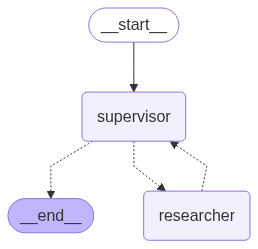

In [41]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [42]:
from langchain_core.messages import HumanMessage

def summary_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    prompt = """
    You are a summary agent.

    Your role is to take raw research content and turn it into a clean, simplified summary for decision-makers.

    Your summary must:
    - Highlight the most important 3–5 insights in bullet points
    - Include relevant quotes, facts, or numbers (if present)
    - Mention any sources or authors cited
    - Avoid fluff or repetition — make it tight and powerful

    Format:
    === Research Summary ===
    - Insight 1
    - Insight 2
    ...

    If quotes or data are used, clearly attribute them.

    Prefix your final answer with **'Final Answer:'** so the supervisor knows you’re done.
    """.strip()

    summary_agent_instance = SummaryAgent()
    tools = [summary_agent_instance.tools[0]]

    agent = create_react_agent(
        llm,
        tools=tools,
        prompt=prompt
    )

    result = agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="summarizer")
            ]
        },
        goto="supervisor"
    )


In [43]:
def chart_generation_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    agent = SummaryAgent()
    chart_tool = [agent.tools[1]]  # Just the chart generation tool

    prompt = """
    You are a chart generation assistant.
    Based on previous summary or data, use the appropriate chart tool to visualize insights.
    Choose the best chart type (bar/pie/line) depending on data pattern.
    Output should be concise and include only the generated chart or its location.
    Prefix final output with **Final Answer:**
    """.strip()

    react_agent = create_react_agent(llm, tools=chart_tool, prompt=prompt)
    result = react_agent.invoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="chart_generator")]},
        goto="supervisor"
    )

In [44]:

summary_team_prompt = """
You are the SummaryTeam Supervisor Agent.

Your job is to manage two agents responsible for turning research into insightful and visual summaries. Here’s what each agent does:

1. summary_node:
   - Summarizes the raw research content.
   - Extracts 3–5 key insights.
   - Writes a clean, bullet-style summary suitable for decision-makers.

2. chart_generation_node:
   - Generates charts (bar, pie, line) based on the summary or underlying data.
   - Visualizes the most important trends or numeric breakdowns.

Your job:
- Decide which agent to activate next based on the current state of the conversation.
- You can call agents in any order.
- Once **both agents have completed their task**, respond with `FINISH`.

Important rules:
- Only return one of the following options in the `next` field:
  • `summary_node`
  • `chart_generation_node`
  • `FINISH`
- Do NOT repeat agents that have already completed their task.
- Avoid calling `FINISH` early.

Think like a project manager. Use agent outputs to decide the next best step.
""".strip()
summarizer_supervisor_node = make_supervisor_node(
    llm, ["summarizer", "chart_generator"],summary_team_prompt
)

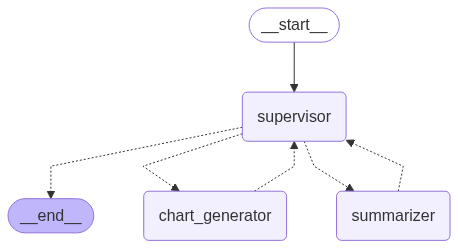

In [45]:
summarizer_builder = StateGraph(State)
summarizer_builder.add_node("supervisor", summarizer_supervisor_node)
summarizer_builder.add_node("summarizer", summary_node)

summarizer_builder.add_node("chart_generator", chart_generation_node)

summarizer_builder.add_edge(START, "supervisor")
summarizer_graph = summarizer_builder.compile()
summarizer_graph

In [46]:
from langchain_core.messages import HumanMessage

def task_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # Step 1: Setup TaskAgent + tools
    task_agent_instance = TaskAgent()
    tools = task_agent_instance.tools  # Already a list

    agent = create_react_agent(
        llm,
        tools=tools,
        prompt="""
You are a task planner assistant designed to turn a research summary into an actionable exploration and learning plan.

Your mission:
- Read the provided research summary (you'll find it in the context).
- Output a clear, well-structured **task plan** to help someone go from insight → action.
- Be tactical, avoid vague suggestions.
- Stick to the format below.

---

### 📘 What to Learn
List 4–6 highly specific technical topics based on the summary.
Example: “Understand how LangGraph handles node memory transitions.”

---

### 🧰 Tools / APIs to Explore
List 3–5 APIs, tools, or frameworks. Add 1-line reasoning for each.

---

### 👥 People / Roles to Connect With
Suggest profiles like “LLM ops engineers” or “backend devs integrating OpenAI”.

---

### 🧪 Micro-Experiments to Try
Quick MVPs, validation runs, tests. Be practical.

---

### 🧭 3-Phase Plan

**Phase 1: Learn & Observe**
- 2–3 focused learning tasks

**Phase 2: Build & Explore**
- 2–3 hands-on experiments

**Phase 3: Reflect & Iterate**
- 1–2 reflective or pivoting ideas

---

Prefix your final output with **'Final Answer:'** so the supervisor can detect you’re done.
""".strip()
    )

    # Step 2: Run it
    result = agent.invoke(state)

    # Step 3: Return message to reporter_track
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="tasker")
            ]
        },
        goto="supervisor",
    )


In [47]:
from langchain_core.messages import HumanMessage

def report_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # Step 1: Setup tools properly
    report_agent_instance = ReportAgent()
    tools = report_agent_instance.tools  # Already a list

    agent = create_react_agent(
        llm,
        tools=tools,
        prompt="""
You are a reporting agent responsible for generating a final report using:
- The research summary
- The task plan

Your job is to take these inputs and call the `generate_report` tool to create a final deliverable in PDF, DOCX, or PPTX format.

Steps:
1. Parse the topic, summary, and tasks from the conversation context.
2. Call the tool with the correct values.
3. Output ONLY the tool result (which will include the file path).

Important:
- Use "pdf" as the default format unless otherwise stated.
- Do not invent or hallucinate missing sections. Raise an error if any input is missing.
- Prefix your result with **Final Answer:** so the Supervisor can recognize your output.
""".strip()
    )

    # Step 2: Run it
    result = agent.invoke(state)

    # Step 3: Return updated message and loop back into reporter_track
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="reporter")
            ]
        },
        goto="supervisor",
    )


In [48]:
report_team_prompt = """
You are the Supervisor Agent for the Report Generation Track.

You manage two agents:

1. tasker:
   - Takes summarized research and turns it into a structured, actionable task plan.
   - Focuses on learning objectives, tools, people to connect with, micro-experiments, and a phased execution plan.
   - Returns a tactical and practical breakdown, prefixed with **Final Answer**.

2. reporter:
   - Reads the final summary and task plan.
   - Calls the `generate_report` tool to create a polished report in PDF/DOCX/PPT format.
   - Outputs the report location, prefixed with **Final Answer**.

Your job:
- Decide which agent to activate next based on the current state of the conversation.
- Ensure that `tasker` completes first, then `reporter` finalizes the deliverable.
- Once the report has been generated successfully, respond with `FINISH`.

Only respond with one of the following in the `next` field:
- `tasker`
- `reporter`
- `FINISH`

Use the message history to decide the correct step. Avoid repeating steps already completed unless necessary.
""".strip()
report_supervisor_node = make_supervisor_node(
    llm, ["reporter"],report_team_prompt
)


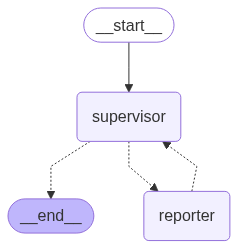

In [49]:
reporter_builder = StateGraph(State)
reporter_builder.add_node("supervisor", report_supervisor_node)
# reporter_builder.add_node("tasker", task_node)

reporter_builder.add_node("reporter", report_node)

reporter_builder.add_edge(START, "supervisor")
reporter_graph = reporter_builder.compile()
reporter_graph

In [433]:
teams_supervisor_prompt = """
You are the top-level Supervisor Agent responsible for coordinating the entire multi-step workflow.

There are 3 major teams you manage:

1. research_team:
   - Gathers raw, up-to-date insights from the internet.
   - This team completes once the research content is fully collected.

2. summary_team:
   - Converts research into a concise, executive-level summary.
   - Optionally generates supporting charts or visualizations.

3. report_team:
   - Translates the summarized insights into a tactical task plan.
   - Then generates a polished final report in PDF, DOCX, or PPT format.

Your job:
- Activate one team at a time based on the current progress.
- Follow this general flow: `research_team → summary_team → report_team`.
- Only proceed to the next team when the current one is complete.
- Once all 3 teams are done, respond with `FINISH`.

Return only one of the following options in the `next` field:
- `research_team`
- `summary_team`
- `report_team`
- `FINISH`

Use the message history to decide what's complete and what’s pending.
""".strip()
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "summary_team","report_team"],teams_supervisor_prompt)

In [434]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_summary_team(state: State) -> Command[Literal["supervisor"]]:
    response = summarizer_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="summary_team"
                )
            ]
        },
        goto="supervisor",
    )

def call_report_team(state: State) -> Command[Literal["supervisor"]]:
    response = reporter_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="report_team"
                )
            ]
        },
        goto="supervisor",
    )



In [435]:
# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("summary_team", call_summary_team)
super_builder.add_node("report_team", call_report_team)
super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

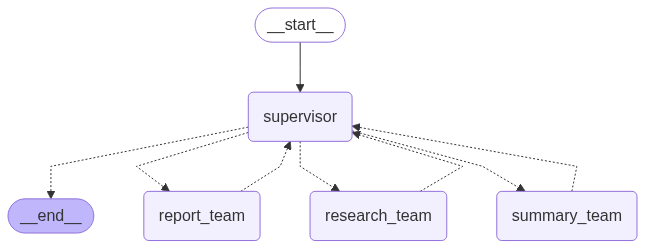

In [436]:
super_graph

In [437]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief summary and report it doc .")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='Final Answer:\n\n=== Topic: AI Agents (2024) ===\n\n1. Key Insights\n   - AI agents are software entities empowered with varying degrees of autonomy to perceive their environment, make decisions, and take actions toward achieving specified goals.\n   - Their capabilities have rapidly advanced, moving from simple rule-based agents to highly autonomous and generalizable models that can operate with minimal human input.\n   - Modern AI agents leverage deep learning, reinforcement learning, and large language models to solve complex, multi-step problems and interact dynamically with humans and data.\n   - In 2024, AI agents are being integrated across sectors, driving productivity by automating data analysis, workflow management, and even creative tasks.\n\n2. Emerging Trends\n   - Autonomy & Modularization: AI agents are increasingly self-directed and are designed as composites of smaller “